In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import structure_model_lib 
import dp_modeling_lib
import data_utils

import paragami

import optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  


In [2]:
np.random.seed(534534)

# Draw data

In [3]:
n_obs = 160
n_loci = 200
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

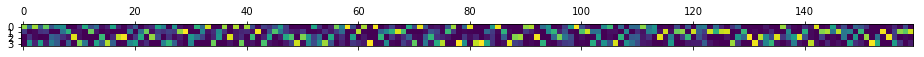

In [4]:
plt.matshow(true_ind_admix_propn.T)

In [8]:
true_ind_admix_propn[0:5, :]

array([[8.26563554e-01, 1.71591604e-01, 1.67440939e-03, 1.70432735e-04],
       [3.40187499e-01, 9.74131557e-04, 1.44628891e-01, 5.14209478e-01],
       [8.50977817e-01, 2.61914356e-02, 2.27244764e-02, 1.00106271e-01],
       [2.93168998e-01, 1.38635124e-01, 3.82973932e-04, 5.67812904e-01],
       [7.59643820e-01, 1.62633888e-01, 6.30744803e-03, 7.14148448e-02]])

In [6]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = n_pop
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (200, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (160, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (160, 3) (lb=0.0001, ub=inf)


In [9]:
ind_mix_stick_propn_mean = vb_params_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_params_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_params_dict['pop_freq_beta_params']

# Set up model

In [11]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [12]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                      true_pop_allele_freq = None, 
                                      true_ind_admix_propn = None)

In [13]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict, free = True)

In [14]:
structure_model_lib.get_kl(g_obs, vb_params_dict,
                   prior_params_dict, gh_loc, gh_weights)

64713.32214051487

In [15]:
get_free_vb_params_loss_cached(init_vb_free_params)

64713.32214051487

In [ ]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 50, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: 43795.519986
         Iterations: 50
         Function evaluations: 59
         Gradient evaluations: 59

 running preconditioned newton; iter =  0
computing preconditioner 


In [ ]:
vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

In [ ]:
ind_mix_stick_propn_mean = vb_opt_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_opt_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_opt_dict['pop_freq_beta_params']

In [ ]:
e_pop_allele_freq = pop_freq_beta_params[:, :, 0] / pop_freq_beta_params.sum(axis=2)

In [ ]:
def find_min_perm(x, y, axis = 0):
    # perumutes array x along axis to find closest 
    # match to y
        
    perms = list(permutations(np.arange(x.shape[axis])))

    i = 0
    diff_best = np.Inf
    for perm in perms: 

        x_perm = x.take(perm, axis)
        
        diff = np.sum((x_perm - y)**2)
        
        if diff < diff_best: 
            diff_best = diff
            i_best = i
        
        i += 1

    return perms[i_best]

In [21]:
perm_best = find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)

In [22]:
e_pop_allele_freq[:, perm_best]

array([[0.92553933, 0.0110584 , 0.01560233, 0.01646585],
       [0.00963405, 0.98609818, 0.01836387, 0.01945906],
       [0.01089783, 0.01387308, 0.98260488, 0.02029114],
       [0.01630353, 0.0152515 , 0.02121923, 0.98607813],
       [0.0091834 , 0.02231597, 0.01778837, 0.03408285]])

In [23]:
true_pop_allele_freq

array([[0.99, 0.01, 0.01, 0.01],
       [0.01, 0.99, 0.01, 0.01],
       [0.01, 0.01, 0.99, 0.01],
       [0.01, 0.01, 0.01, 0.99],
       [0.01, 0.01, 0.01, 0.01]])

In [24]:
e_log_ind_admix = dp_modeling_lib.get_e_log_cluster_probabilities(
                        ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                        gh_loc, gh_weights)[:, perm_best]

In [25]:
e_log_ind_admix.argmax(axis=1)

array([0, 0, 2, 0, 1, 1, 0, 2, 2, 3, 1, 0, 2, 2, 3, 3, 3, 0, 1, 1, 2, 1,
       0, 1, 3, 2, 0, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 0, 0, 1, 3, 2, 3, 3,
       1, 3, 3, 2, 2, 2, 3, 1, 3, 3, 0, 3, 1, 0, 3, 0, 0, 0, 1, 0, 1, 1,
       2, 0, 1, 3, 3, 1, 3, 0, 2, 0, 0, 3, 0, 3, 3, 0, 0, 1, 2, 0, 2, 1,
       3, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3, 2, 2, 3, 0, 1, 2, 0, 2, 3, 1, 0,
       2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 3, 1, 3, 0, 0, 0, 1, 3, 0, 0, 0,
       0, 1, 0, 2, 1, 3, 2, 1, 2, 3, 2, 3, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1,
       2, 1, 0, 1, 1, 2])

In [26]:
true_ind_admix_propn.argmax(axis=1)

array([0, 0, 2, 0, 1, 1, 0, 2, 2, 3, 1, 0, 2, 2, 3, 3, 3, 0, 2, 1, 2, 1,
       0, 1, 3, 2, 0, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 0, 0, 1, 3, 2, 3, 3,
       1, 3, 3, 2, 2, 2, 3, 1, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 1, 0, 1, 1,
       2, 0, 1, 3, 3, 1, 3, 0, 2, 0, 0, 3, 0, 3, 3, 0, 0, 1, 2, 0, 2, 1,
       3, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3, 2, 2, 3, 0, 1, 2, 0, 2, 3, 1, 0,
       2, 1, 2, 2, 0, 3, 0, 1, 2, 0, 2, 3, 1, 3, 0, 0, 0, 1, 3, 0, 0, 0,
       0, 1, 0, 2, 1, 3, 2, 1, 2, 3, 2, 3, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1,
       2, 1, 0, 1, 1, 2])

In [27]:
np.mean(e_log_ind_admix.argmax(axis=1) == \
       true_ind_admix_propn.argmax(axis=1))

0.98125